# Project 6


### Objective
To collect movie data including ratings, visualize the movie attributes against the ratings to determine any correlations, and build a tree based model to predict movie ratings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import requests
import bs4
%matplotlib inline
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
import statsmodels.api as sm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import sys
reload(sys)
import csv
sys.setdefaultencoding('utf8')
#matplotlib.style.use('ggplot') 

#!pip install imdbpie

### Data Collection

I started by using the 1000 best movies of all times according to the New York Times, and I decided that a model to predict rating should also include bad movies as well. From IMDb.com, I scraped 100 movies with the highest number of votes from each rating between 3 and 10 stepping by 0.1.

In [2]:
#scraping movies from imdb -- 100 movies with highest number of votes for each rating from 3-10 stepping by 0.1

url_template = 'http://www.imdb.com/search/title?at=0&sort=num_votes,desc&start={}&title_type=feature&user_rating={}'
max_results = 100
results = []

    
def moviesimdb(soupy):
    mov = soupy.findAll(class_ = "title")
    movies = []
    for i in mov:
        try:
            movies.append(i.text.strip())
        except:
            pass

    return movies

for rating in set(np.arange(3,10,0.1)):
    for start in range(1, max_results, 50):
        response = requests.get(url_template.format(start,rating))
        page = response.text
        soup = BeautifulSoup(page,'lxml')
        results.extend(moviesimdb(soup))

In [3]:
#creating list of movies and stripping '\n'

cleanresults = []
for i in results:
    cleanresults.append(i[:i.find('\n')])

In [4]:
#saving results to csv

with open('movies3.csv', 'wb') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(cleanresults)

In [6]:
#obtaining movie info data from omdbapi

import json
import urllib2

def omdbapi(movies):
    url_template = "http://www.omdbapi.com/?t={}&plot=short&r=json"

    results = []
    errors = []

    for i in set(movies):
        i = i.replace(" ","+")
        a = json.load(urllib2.urlopen(url_template.format(i)))
        if a['Response'] == "True" and a['Type'] != 'series':
            results.append(a)
    return results

omdbresults = omdbapi(cleanresults)

In [589]:
df = pd.DataFrame(omdbresults)
df.head(3)

,Actors,Awards,Country,Director,Genre,Language,Metascore,Plot,Poster,Rated,Released,Response,Runtime,Title,Type,Writer,Year,imdbID,imdbRating,imdbVotes
0,"Jenn Proske, Matt Lanter, Diedrich Bader, Chri...",6 nominations.,USA,"Jason Friedberg, Aaron Seltzer",Comedy,"English, German",18,"A spoof of vampire-themed movies, where teenag...",http://ia.media-imdb.com/images/M/MV5BMTk2MDk0...,PG-13,18 Aug 2010,True,82 min,Vampires Suck,movie,"Jason Friedberg, Aaron Seltzer",2010,tt1666186,3.5,"38,839"
1,"Viggo Mortensen, Kodi Smit-McPhee, Robert Duva...",Nominated for 1 BAFTA Film Award. Another 5 wi...,USA,John Hillcoat,"Adventure, Drama",English,64,"In a dangerous post-apocalyptic world, an aili...",http://ia.media-imdb.com/images/M/MV5BMTAwNzk4...,R,18 Dec 2009,True,111 min,The Road,movie,"Cormac McCarthy (novel), Joe Penhall (screenplay)",2009,tt0898367,7.3,"176,165"
2,"Jim Carrey, Zooey Deschanel, Bradley Cooper, J...",3 wins & 7 nominations.,"USA, UK",Peyton Reed,"Comedy, Romance","English, Korean, Estonian",46,"A guy challenges himself to say ""yes"" to every...",http://ia.media-imdb.com/images/M/MV5BNjYyOTky...,PG-13,19 Dec 2008,True,104 min,Yes Man,movie,"Nicholas Stoller (screenplay), Jarrad Paul (sc...",2008,tt1068680,6.8,"269,547"


In [590]:
#deleting unnecessary columns

del df['Plot']
del df['Poster']
del df['Writer']
del df['imdbID']
del df['Released']
del df['Response']
del df['Type']
del df['Actors']
del df['Director']
del df['Metascore']

In [591]:
#replacing 'N/A' with NaN
#dropping movies with NaN values in specific columns


df = df.replace({"N/A":np.nan})
df = df.dropna(subset=['Country'], how='all')
df = df.dropna(subset=['Genre'], how='all')
df = df.dropna(subset=['Language'], how='all')
df = df.dropna(subset=['Runtime'], how='all')
df = df.dropna(subset=['imdbRating'], how='all')
df = df.dropna(subset=['imdbVotes'], how='all')



### Data Cleaning and Binarizing

In [592]:
#cleaning runtime by removing 'min'
#cleaning imdbVotes be removing commas and turning strings to np.nan
#cleaning imdbVotes be removing commas and also deleting movies with less than 500 votes

df['Runtime'] = df['Runtime'].apply(lambda x: int(x[:len(x)-4]))
df['imdbVotes'] = df.imdbVotes.apply(lambda x: int(x.replace(',','')))
df['Year'] = df.Year.apply(lambda x: int(x))

df = df[df.imdbVotes>500]

df['Country'] = df.Country.apply(lambda x: x.split(',')[0])
df['Country'] = df.Country.apply(lambda x: "Germany" if x == "West Germany" else x)

df['imdbRating'] = df.imdbRating.apply(lambda x: float(x))

df = df.reset_index()
del df['index']

#### Total Number of Movies in this dataset: 

In [593]:
len(df)

5527

In [594]:
#separating genres for movies with more than one listed.

def genrecounts(value):
    value.split(', ')
    Drama,Romance,Comedy,Thriller,Biography,Adventure,Mystery,Crime,Documentary,History,SciFi,FilmNoir,Action = 0,0,0,0,0,0,0,0,0,0,0,0,0
    if "Drama" in value:
        Drama +=1
    if "Romance" in value:
        Romance +=1
    if "Comedy" in value:
        Comedy +=1
    if "Thriller" in value:
        Thriller +=1
    if "Biography" in value:
        Biography +=1
    if "Adventure" in value:
        Adventure +=1
    if "Mystery" in value:
        Mystery +=1
    if "Crime" in value:
        Crime +=1
    if "Documentary" in value:
        Documentary +=1
    if "History" in value:
        History +=1
    if "Sci-Fi" in value:
        SciFi +=1
    if "Film-Noir" in value:
        FilmNoir +=1
    if "Action" in value:
        Action +=1
    return Drama,Romance,Comedy,Thriller,Biography,Adventure,Mystery,Crime,Documentary,History,SciFi,FilmNoir,Action

dfgenrescount = df.Genre.to_frame().applymap(genrecounts)

In [595]:
dfgenrescount.head()

,Genre
0,"(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)"
1,"(1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0)"
2,"(0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)"
3,"(0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)"
4,"(1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)"


In [596]:
#adding dfgenrescount to dataframe

dfgenres = pd.DataFrame(columns = ["Drama","Romance","Comedy","Thriller","Biography","Adventure","Mystery","Crime","Documentary","History","SciFi",
                                   "FilmNoir","Action"])

for i in range(len(dfgenrescount)):
    dfgenres.loc[i] = [x for x in dfgenrescount.Genre[i]]
dfgenres.head()

,Drama,Romance,Comedy,Thriller,Biography,Adventure,Mystery,Crime,Documentary,History,SciFi,FilmNoir,Action
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [597]:
#creating keys for merging the dataframes
#merging genres df with main df

df['key'] = [x for x in range(len(df))]
dfgenres['key'] = [x for x in range(len(dfgenres))]
df = pd.merge(df,dfgenres,on = 'key')
del df['key']

In [598]:
countrylist = []
for i in range(len(df.Country.value_counts())):
    if df.Country.value_counts()[i]>25:
        countrylist.append(df.Country.value_counts().index[i])
countrylist

[u'USA',
 u'UK',
 u'India',
 u'France',
 u'Canada',
 u'Germany',
 u'Japan',
 u'Italy',
 u'Turkey',
 u'Spain',
 u'Australia',
 u'Soviet Union']

In [599]:
#adding dummies for countries
df['CountryTop']= df.Country.apply(lambda x: x if x in countrylist else 'Other')
df['key'] = range(len(df['CountryTop']))
df = pd.concat([df.drop('key',axis=1),pd.get_dummies(df['CountryTop'])], axis = 1)
df.head(3)

,Awards,Country,Genre,Language,Rated,Runtime,Title,Year,imdbRating,imdbVotes,...,Germany,India,Italy,Japan,Other,Soviet Union,Spain,Turkey,UK,USA
0,6 nominations.,USA,Comedy,"English, German",PG-13,82,Vampires Suck,2010,3.5,38839,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Nominated for 1 BAFTA Film Award. Another 5 wi...,USA,"Adventure, Drama",English,R,111,The Road,2009,7.3,176165,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3 wins & 7 nominations.,USA,"Comedy, Romance","English, Korean, Estonian",PG-13,104,Yes Man,2008,6.8,269547,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [600]:
#binarizing language to English/Not English

df['LangEnglish'] = df.Language.apply(lambda x: 1 if "English" in x else 0)

In [601]:
#binarizing awards to containing 'Oscar' or not.

def oscars(value):
    try:
        if "Oscar" in value:
            return 1
        else: return 0
    except:
        return 0
    

df['Awards'] = df.Awards.to_frame().applymap(oscars)
df.head(3)

,Awards,Country,Genre,Language,Rated,Runtime,Title,Year,imdbRating,imdbVotes,...,India,Italy,Japan,Other,Soviet Union,Spain,Turkey,UK,USA,LangEnglish
0,0,USA,Comedy,"English, German",PG-13,82,Vampires Suck,2010,3.5,38839,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,0,USA,"Adventure, Drama",English,R,111,The Road,2009,7.3,176165,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,0,USA,"Comedy, Romance","English, Korean, Estonian",PG-13,104,Yes Man,2008,6.8,269547,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [602]:
#creating dummies for ratings

#ratings = ['R','PG','PG-13','G','X','M','NC-17']
#df['Rated'] = df.Rated.apply(lambda x: x if x in ratings else "Other")
df['key'] = range(len(df['Rated']))
df = pd.concat([df.drop('key',axis=1),pd.get_dummies(df['Rated'])], axis = 1)
df.head(3)

,Awards,Country,Genre,Language,Rated,Runtime,Title,Year,imdbRating,imdbVotes,...,NOT RATED,PASSED,PG,PG-13,R,TV-14,TV-MA,TV-PG,UNRATED,X
0,0,USA,Comedy,"English, German",PG-13,82,Vampires Suck,2010,3.5,38839,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,USA,"Adventure, Drama",English,R,111,The Road,2009,7.3,176165,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,USA,"Comedy, Romance","English, Korean, Estonian",PG-13,104,Yes Man,2008,6.8,269547,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [603]:
measures = [round(df.imdbRating.mean(),2),round(df.imdbRating.median(),2), str(len(df))]
measuresdf = pd.DataFrame(measures,columns = ['Value'],index = ["Mean Rating","Median Rating","Total Movies"])
measuresdf

,Value
Mean Rating,5.95
Median Rating,6
Total Movies,5527


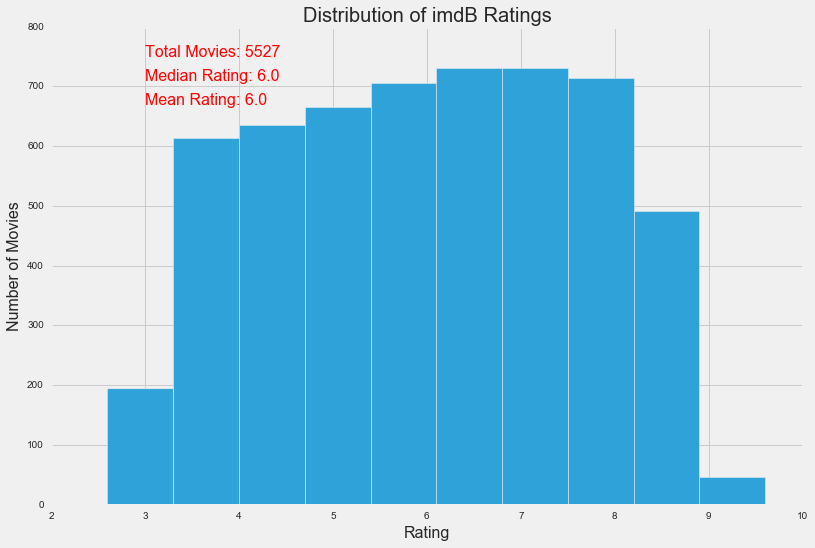

In [604]:
plt.figure()
df.imdbRating.plot.hist(bins = 10,figsize = (12,8))
plt.xlabel('Rating', fontsize = 16)
plt.xticks()
plt.ylabel('Number of Movies', fontsize = 16)
plt.text(3,750,'Total Movies: '+str(len(df)),fontsize = 16,color = 'red')
plt.text(3,710,'Median Rating: '+str(df.imdbRating.median()),fontsize = 16,color = 'red')
plt.text(3,670,'Mean Rating: '+str(round(df.imdbRating.mean())),fontsize = 16,color = 'red')
plt.title("Distribution of imdB Ratings")
plt.style.use('fivethirtyeight')


The ratings of the movies in the dataset are well distributed as illustrated above with median rating of 6.0.

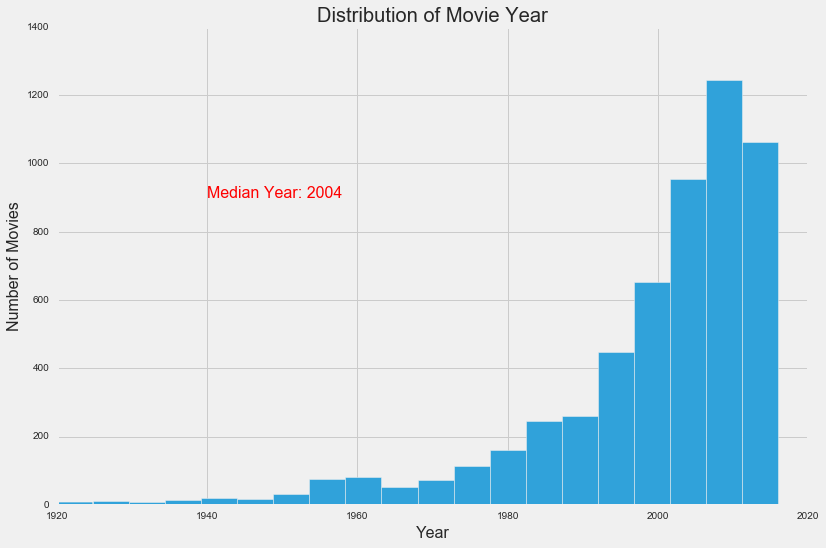

In [605]:
plt.figure()
df.Year.plot.hist(bins = 20,figsize = (12,8))
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Number of Movies', fontsize = 16)
plt.text(1940,900,'Median Year: '+str(int(df.Year.median())),fontsize = 16,color = 'red')
plt.title("Distribution of Movie Year")
plt.style.use('fivethirtyeight')

The movies are heavily skewed towards recent years with a median year of 2004. 

In [606]:
usapercent = str(round(len(df[df.Country == 'USA'])/float(len(df))*100,1))

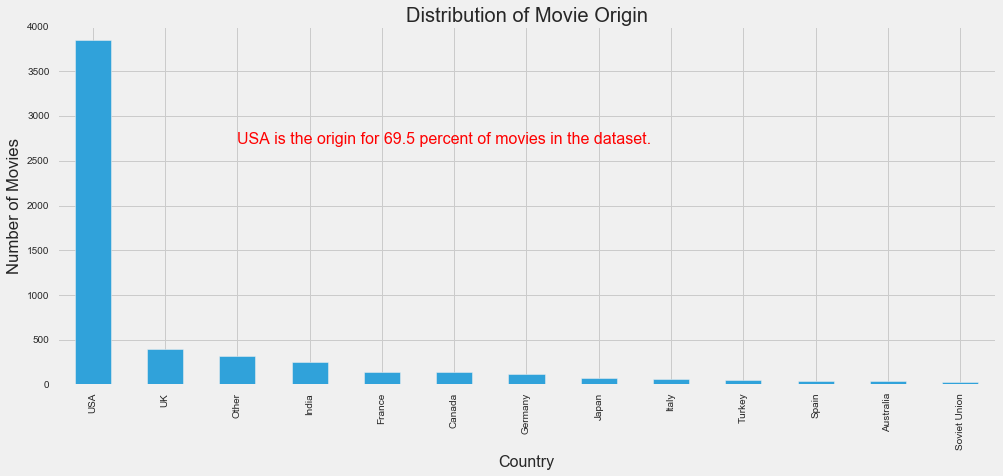

In [607]:
#plotting the number of movies per country
plt.figure()
df.CountryTop.value_counts().plot(kind = 'bar', figsize = (15,6))
plt.xlabel('Country', fontsize = 16)
plt.ylabel('Number of Movies')
plt.text(2,2700,'USA is the origin for %s percent of movies in the dataset.' %(usapercent),fontsize = 16,color = 'red')
plt.title("Distribution of Movie Origin")
plt.style.use('fivethirtyeight')

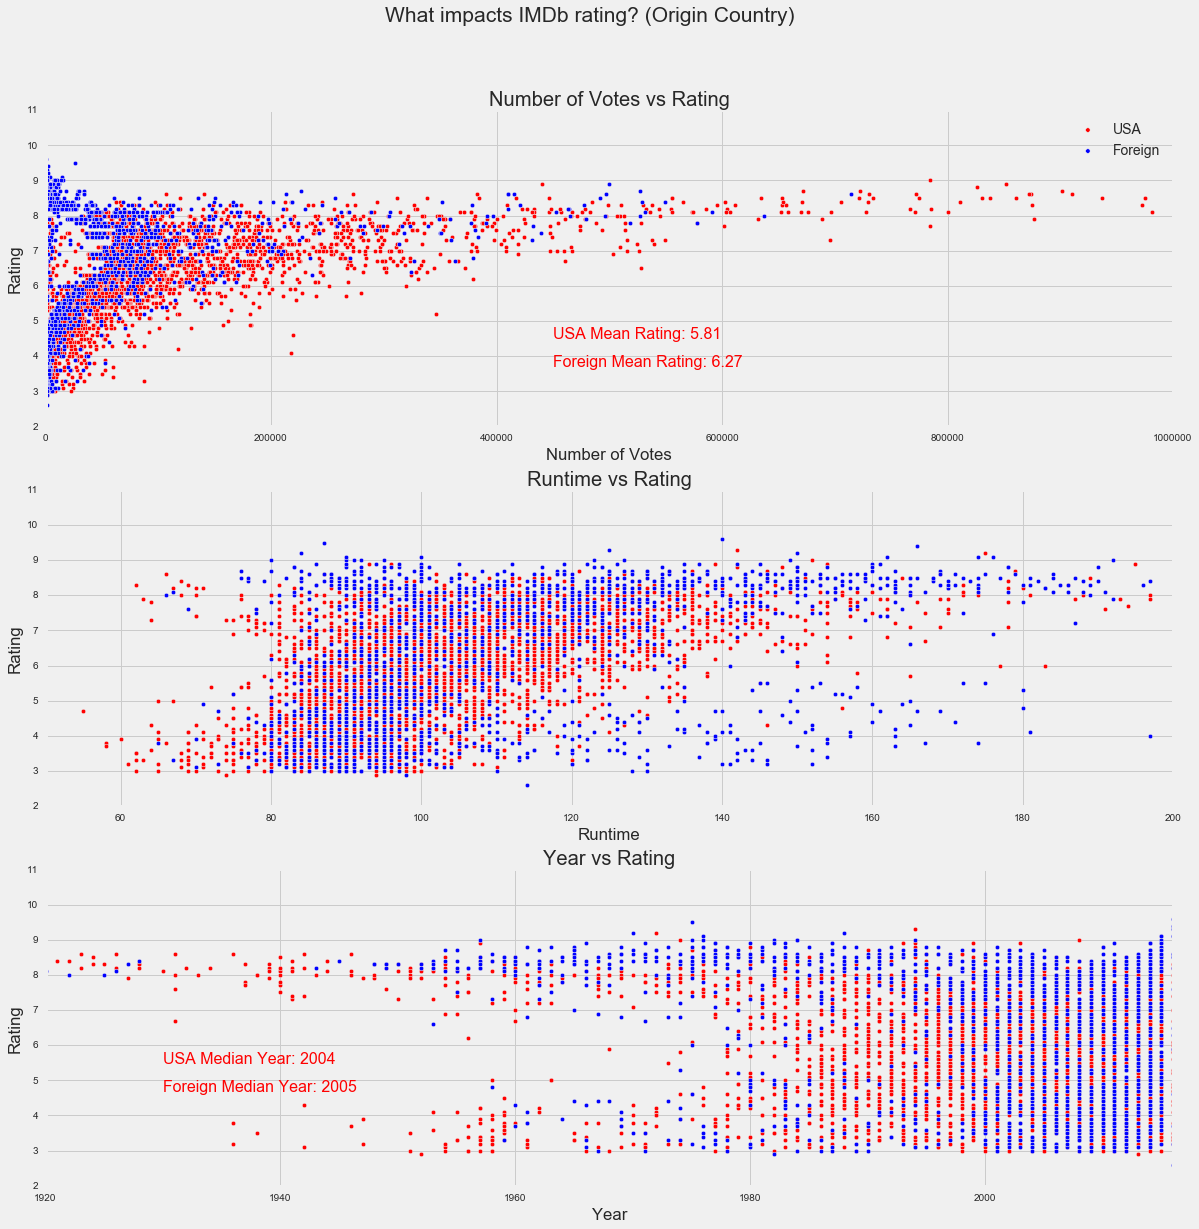

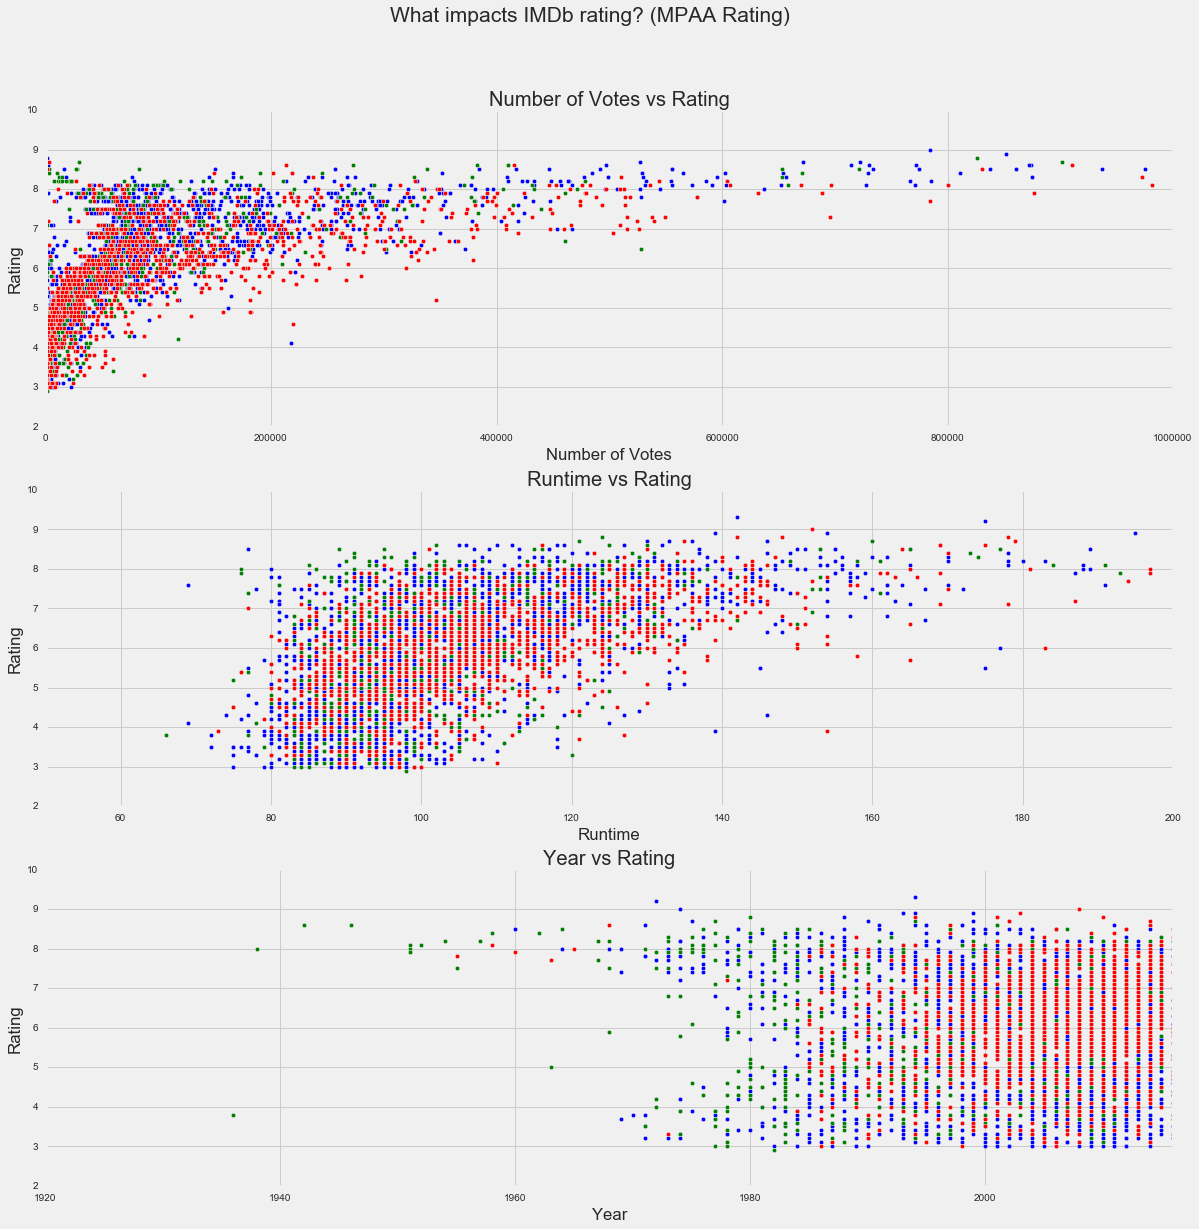

In [608]:
#tempdfusa = df[df.Country == 'USA']
#tempdfnotusa = df[df.Country != 'USA']


tempdfratingR = df[df.Rated == 'R']
tempdfratingPG = df[df.Rated == 'PG']
tempdfratingPG13 = df[df.Rated == 'PG-13']
tempdfratingNR = df[df.Rated == 'Not Rated']

usarating = str(round(df[df.Country=='USA'].imdbRating.mean(),2))
foreignrating = str(round(df[df.Country!='USA'].imdbRating.mean(),2))
usayear = int(df[df.Country=='USA'].Year.median())
foreignyear = int(df[df.Country!='USA'].Year.median())

fig = plt.figure(figsize = (18,18))

ax1 = fig.add_subplot(311)
ax1.scatter(tempdfusa.imdbVotes,tempdfusa.imdbRating, c='r')
ax1.scatter(tempdfnotusa.imdbVotes,tempdfnotusa.imdbRating, c='b')
ax1.set_xlim([0,1000000])
ax1.legend(['USA','Foreign'],fontsize = 'medium')
plt.text(450000,4.5,'USA Mean Rating: %s' %(usarating),fontsize = 16,color = 'red')
plt.text(450000,3.7,'Foreign Mean Rating: %s' %(foreignrating),fontsize = 16,color = 'red')
ax1.set_title("Number of Votes vs Rating")
ax1.set_xlabel("Number of Votes")
ax1.set_ylabel("Rating")

ax2 = fig.add_subplot(312)
ax2.scatter(tempdfusa.Runtime,tempdfusa.imdbRating, c='r')
ax2.scatter(tempdfnotusa.Runtime,tempdfnotusa.imdbRating, c='b')
ax2.set_xlim([50,200])
ax1.legend(['USA','Foreign'],fontsize = 'medium')
ax2.set_title("Runtime vs Rating")
ax2.set_xlabel("Runtime")
ax2.set_ylabel("Rating")

ax3 = fig.add_subplot(313)
ax3.scatter(tempdfusa.Year,tempdfusa.imdbRating, c='r')
ax3.scatter(tempdfnotusa.Year,tempdfnotusa.imdbRating, c='b')
ax3.set_xlim([1920,2016])
ax1.legend(['USA','Foreign'],fontsize = 'medium')
plt.text(1930,5.5,'USA Median Year: %d' %(usayear),fontsize = 16,color = 'red')
plt.text(1930,4.7,'Foreign Median Year: %d' %(foreignyear),fontsize = 16,color = 'red')
ax3.set_title("Year vs Rating")
ax3.set_xlabel("Year")
ax3.set_ylabel("Rating")

fig.suptitle('What impacts IMDb rating? (Origin Country)', fontsize=21);


fig = plt.figure(figsize = (18,18))

ax4 = fig.add_subplot(311)
ax4.scatter(tempdfratingR.imdbVotes,tempdfratingR.imdbRating, c='blue')
ax4.scatter(tempdfratingPG.imdbVotes,tempdfratingPG.imdbRating, c='green')
ax4.scatter(tempdfratingPG13.imdbVotes,tempdfratingPG13.imdbRating, c='red')
ax4.scatter(tempdfratingNR.imdbVotes,tempdfratingNR.imdbRating, c='darkblue')
ax4.set_xlim([0,1000000])
ax4.set_title("Number of Votes vs Rating")
ax4.set_xlabel("Number of Votes")
ax4.set_ylabel("Rating")

ax5 = fig.add_subplot(312)
ax5.scatter(tempdfratingR.Runtime,tempdfratingR.imdbRating, c='blue')
ax5.scatter(tempdfratingPG.Runtime,tempdfratingPG.imdbRating, c='green')
ax5.scatter(tempdfratingPG13.Runtime,tempdfratingPG13.imdbRating, c='red')
ax5.scatter(tempdfratingNR.Runtime,tempdfratingNR.imdbRating, c='darkblue')
ax5.set_xlim([0,1000000])
ax5.set_xlim([50,200])
ax5.set_title("Runtime vs Rating")
ax5.set_xlabel("Runtime")
ax5.set_ylabel("Rating")

ax6 = fig.add_subplot(313)
ax6.scatter(tempdfratingR.Year,tempdfratingR.imdbRating, c='blue')
ax6.scatter(tempdfratingPG.Year,tempdfratingPG.imdbRating, c='green')
ax6.scatter(tempdfratingPG13.Year,tempdfratingPG13.imdbRating, c='red')
ax6.scatter(tempdfratingNR.Year,tempdfratingNR.imdbRating, c='darkblue')
ax4.set_xlim([0,1000000])
ax6.set_xlim([1920,2016])
ax6.set_title("Year vs Rating")
ax6.set_xlabel("Year")
ax6.set_ylabel("Rating")

fig.suptitle('What impacts IMDb rating? (MPAA Rating)', fontsize=21);

The interesting takeaways from the first three graphs above are:

Number of votes
- There is a clear positive relationship between number of votes and rating. Almost every movie with more than 200k votes has an above average rating.
- Foreign movies are more likely to have a higher rating across the board. The mean rating for American movies is 5.81 while the mean for foreign films is 6.27.
- A movie receiving more than 200k votes is far more likely to be American. More than 84% of movies with 200k votes were from the USA.
- There is a very high concentration of foreign movies with a very high rating and few votes. In fact, less than 13% of movies with a better 7.0 rating and less than 36k votes were from the USA.

Runtime
- There is a positive relationship between the length of the movie and its rating. For movies runtimes less than and greater than 120 minutes the mean rating is 5.6 and 7.2 respectively. For movies longer than 180 minutes, the mean rating is a shocking 8.1!
- Movies longer than 2.5 hours (150 minutes) are likely to be foreign by almost 2:1.
- If a long movie (runtime greater than 120 minutes) has a low rating (less than 5), it is overwhelmingly likely to be a foreign film. More than 86% of movies with these qualifications are not American.

Release Year
- Only 5.5% of movies before 1980 have an average rating (between 5 and 7) meaning as people rate older movies, their impressions are almost binary and these movies have either very high or very low ratings as a result. Also, movies from this time period that are "average" don't stand out and are less likel to be receive votes in the first place. An older movie that's either great or awful is more likely to receive the attention and also the votes.

#### The calculations for the above analysis:

In [609]:
a = df[df.imdbVotes>200000]
b = a[a.Country=='USA']
len(b)/float(len(a))

0.8441330998248686

In [610]:
c = df[df.imdbVotes<36000]
d = c[c.imdbRating > 7]
e = d[d.Country=='USA']
len(e)/float(len(d))

0.1278538812785388

In [611]:
df[df.Runtime<120].imdbRating.mean()

5.604290657439446

In [612]:
df[df.Runtime>120].imdbRating.mean()

7.222731277533041

In [613]:
df[df.Runtime>180].imdbRating.mean()

8.105084745762712

In [614]:
f = df[df.Runtime>150]
g = f[f.Country == 'USA']
len(g)/float(len(f))

0.34572490706319703

In [615]:
h = df[df.Runtime>120]
i = h[h.imdbRating < 5]
j = i[i.Country == 'USA']
len(j)/float(len(i))

0.13131313131313133

In [616]:
k = df[df.Year<1980]
l = k[df.imdbRating>5]
l = l[df.imdbRating<7]
len(l)/float(len(k))

0.05516014234875445

In [617]:
#removing columns no longer needed

del df['Country']
del df['Language']
del df['Genre']
del df['CountryTop']
del df['Rated']
df.head(3)

,Awards,Runtime,Title,Year,imdbRating,imdbVotes,Drama,Romance,Comedy,Thriller,...,NOT RATED,PASSED,PG,PG-13,R,TV-14,TV-MA,TV-PG,UNRATED,X
0,0,82,Vampires Suck,2010,3.5,38839,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,111,The Road,2009,7.3,176165,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,104,Yes Man,2008,6.8,269547,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model Fitting

In [618]:
#setting X and y

X = df.drop(['Title','imdbRating'],axis=1)
y = df.imdbRating

In [619]:
#setting train and test datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)

In [620]:
#decisiontree regressor model

from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=1)
dt.fit(X_train,y_train)
dtpreds = dt.predict(X_test)

In [621]:
#randomforest regressor model

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
rfpreds = rf.predict(X_test)

In [622]:
#adaboost regressor model

from sklearn.ensemble import AdaBoostRegressor
ab = AdaBoostRegressor()
ab.fit(X_train,y_train)
abpreds = ab.predict(X_test)

In [623]:
#gradient boost regressor model

from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor()
gb.fit(X_train,y_train)
gbpreds = gb.predict(X_test)

### Feature Importance

In [624]:
featureimportance = pd.DataFrame(gb.feature_importances_.round(3),index = X.columns,columns=['Importance']).sort_values('Importance',ascending=False)
featureimportance.head(10)

,Importance
imdbVotes,0.258
Year,0.206
Runtime,0.120
Other,0.047
LangEnglish,0.036
Action,0.033
India,0.032
Drama,0.030
Documentary,0.026
Turkey,0.024


### Model Evaluation

In [625]:
from sklearn.cross_validation import KFold, cross_val_score

cv = KFold(len(y), shuffle=True)

dtscores = cross_val_score(dt, X, y, cv=cv)
rfscores = cross_val_score(rf, X, y, cv=cv)
abscores = cross_val_score(ab, X, y, cv=cv)
gbscores = cross_val_score(gb, X, y, cv=cv)

In [628]:
models = ['DecisionTree','RandomForest', 'AdaBoost','GradientBoost']
modelscores = [dtscores.mean(),rfscores.mean(),abscores.mean(),gbscores.mean()]
scoresdf = pd.DataFrame(columns = ['Model','CV Score'])
for i in range(len(models)):
    scoresdf.loc[i] = [models[i],round(modelscores[i],3)]
scoresdf

,Model,CV Score
0,DecisionTree,0.579
1,RandomForest,0.751
2,AdaBoost,0.547
3,GradientBoost,0.760


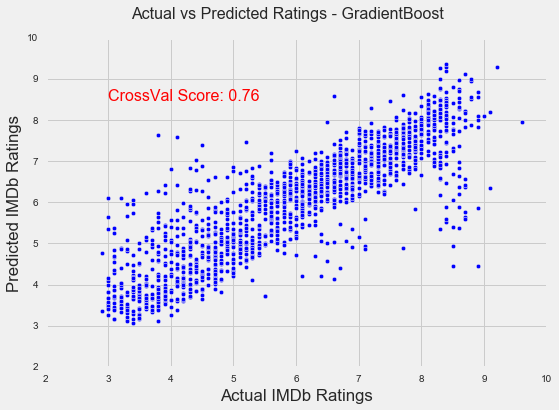

In [629]:
#### plotting predicted values against actuals for GB Regressor

plt.scatter(y_test.values,gbpreds)
#m,b = np.polyfit(y_test,gbpreds,1)
#plt.plot(y_test,(m*y_test+b), linewidth=1, color='black')
plt.suptitle('Actual vs Predicted Ratings - GradientBoost', fontsize=16)
plt.text(3,8.5,'CrossVal Score: %s' % str(round(gbscores.mean(),3)),fontsize = 16,color= 'r')
plt.xlabel('Actual IMDb Ratings')
plt.ylabel('Predicted IMDb Ratings')